In [1]:
%matplotlib inline
# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd

# visualization
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('data.csv', encoding = "ISO-8859-1")

#convert day to datetime type
df.start = pd.to_datetime(df.start)
df.end = pd.to_datetime(df.end)
df.dob = pd.to_datetime(df.dob)
df.dtypes

#elo gain from each tournament
df['delo'] = df.endelo64 - df.startelo64

#cumulative sum of delo
cumsums = df[['player', 'start', 'delo']].groupby(['player', 'start']).sum().groupby(level=0).cumsum()
df = df.set_index(['player', 'start'])
df['rating'] = cumsums
df = df.reset_index()

#calculate age in year
df['age'] = (df.start - df.dob) / pd.Timedelta(days=365.25)

#experience
for player in df.player.unique():
    try:
        dfid = pd.DataFrame(df[df['player'] == player].sort_values('start').tour.unique()).reset_index().rename(columns={'index': 'exp', 0: 'tour'})
        dfid['player'] = player
        dfid2 = pd.concat([dfid2, dfid])
    except NameError:
        dfid2 = dfid
        continue

df = pd.merge(df, dfid2, how='left', on=['player', 'tour'])

#init is rating + initial mmr (assume first team = player's calibration)
init = df[df['startelo64'].notnull()].sort_values('start')[['startelo64', 'player']].groupby('player').first().reset_index().rename(columns={'startelo64': 'init'})
df = pd.merge(df, init, how='left', on='player')
df.init = df.rating + df.init

In [3]:
df.sample(5)

,player,start,country,team,position,dob,tour,end,place,prize,startelo64,endelo64,delo,rating,age,exp,init
4622,uuu9,2016-09-28,NaN,Newbee,1,NaT,Mars Dota 2 League 2016 Autumn,2016-10-02,2,50000.0,1145.693221,1185.108524,39.415303,-70.058592,NaN,15.0,1062.253671
5520,w33,2015-10-03,Romania,Team Secret,2,1995-03-06,ESL One New York 2015,2015-10-04,2,57324.0,1138.110176,1195.867055,57.756879,54.495570,20.577687,4.0,1214.123524
229,chessie,2017-11-19,Sweden,CompLexity Gaming,1,1992-12-26,Perfect World Masters,2017-11-26,4,18000.0,1171.651816,1184.409741,12.757925,-770.917425,24.898015,14.0,434.234424
7415,fly,2013-09-11,USA,Fnatic,5,NaT,WePlay Dota2 League Season 2,2013-11-10,4,2000.0,1079.539930,1237.938893,158.398963,2214.054692,NaN,16.0,3433.705169
1106,nono,2016-10-05,China,Team VGJ,2,NaT,World Cyber Arena 2016 Chinese Qualifiers S3,2016-11-12,4,1468.0,NaN,1055.274652,NaN,NaN,NaN,3.0,NaN


In [4]:
df = df.dropna()

In [5]:
df['season'] = 'ti3'
df.loc[(df.start > pd.to_datetime('2012-08-26')) & (df.start <= pd.to_datetime('2013-08-02')), 'season'] = 'ti3'
df.loc[(df.start > pd.to_datetime('2013-08-02')) & (df.start <= pd.to_datetime('2014-07-08')), 'season'] = 'ti4'
df.loc[(df.start > pd.to_datetime('2014-07-08')) & (df.start <= pd.to_datetime('2015-07-27')), 'season'] = 'ti5'
df.loc[(df.start > pd.to_datetime('2015-07-27')) & (df.start <= pd.to_datetime('2016-08-02')), 'season'] = 'ti6'
df.loc[(df.start > pd.to_datetime('2016-08-02')) & (df.start <= pd.to_datetime('2017-08-02')), 'season'] = 'ti7'
df.loc[(df.start > pd.to_datetime('2017-08-02')) & (df.start <= pd.to_datetime('2018-08-02')), 'season'] = 'ti8'

In [6]:
Region = {'SEA' : ['Malaysia', 'Singapore', 'Thailand', 'Australia', 'South Korea', 'Philippines', 'Vietnam', 'Indonesia'], 
          'EU': ['France', 'Germany', 'Finland', 'Israel', 'Denmark', 'Romania', 'Jordan', 'Sweden', 'Estonia', 'Macedonia', 'Poland', 'Croatia', 'Greece', 'Lebanon', 'Albenia', 'Bosnia and Herzegovina', 'Netherlands', 'Serbia', 'Bulgaria', 'United Kingdom', 'Turkey', 'Slovakia', 'Czech Republic'],
          'CIS': ['Ukraine', 'Russia', 'Belarus', 'Kazakhstan', 'Kyrgyzstan'],
          'CN': ['China', 'Macau'],
          'NA': ['United State', 'Canada', 'Pakistan', 'Mexico'],
          'SA': ['Peru', 'Argentina', 'Brazil', 'Venezuela']}

In [7]:
# divide country into 5 group by region
df['region'] = 'America'
df.loc[df.country.isin(Region['SEA']), 'region'] = 'Sea'
df.loc[df.country.isin(Region['EU']), 'region'] = 'Eu'
df.loc[df.country.isin(Region['CIS']), 'region'] = 'Cis'
df.loc[df.country.isin(Region['CN']), 'region'] = 'China'

In [8]:
# divide experience to 4 groups
# age to 3 group
df['expc'] = pd.qcut(df.exp, 4)
df['agec'] = pd.cut(df.age, 3)

In [9]:
#pos 1 = core, pos 2 = support
df['pos'] = 'core'
df.loc[df['position'] > 3, 'pos'] = 'support'

In [10]:
sns.set_style('whitegrid')

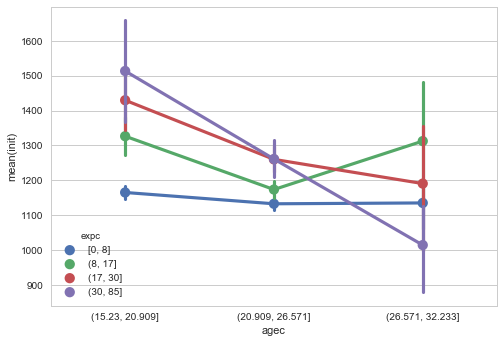

In [11]:
sns.pointplot(x="agec", y="init", hue="expc", data=df)

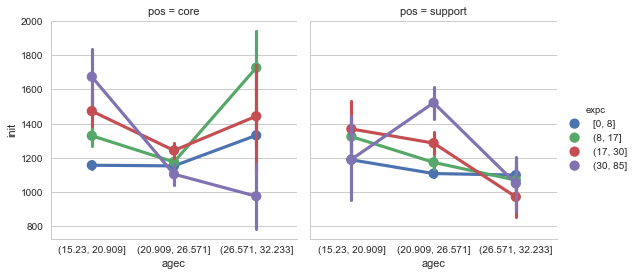

In [12]:
g = sns.factorplot(x="agec", y="init", hue="expc",
                  col="pos", data=df)

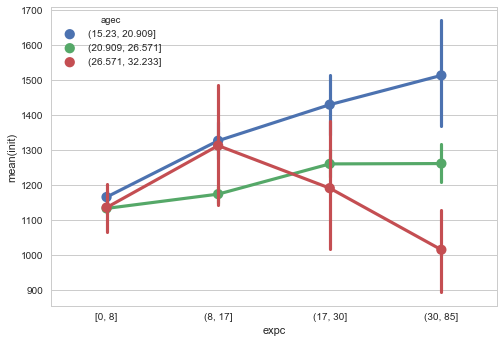

In [13]:
sns.pointplot(x="expc", y="init", hue="agec", data=df)

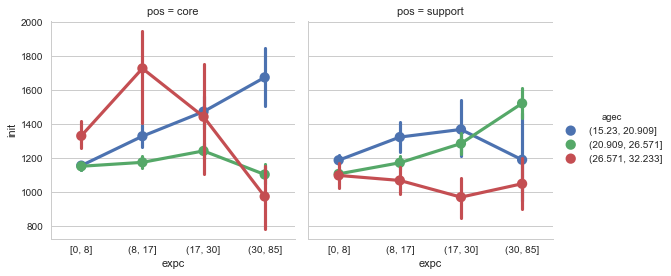

In [14]:
g = sns.factorplot(x="expc", y="init", hue="agec",
                  col="pos", data=df)

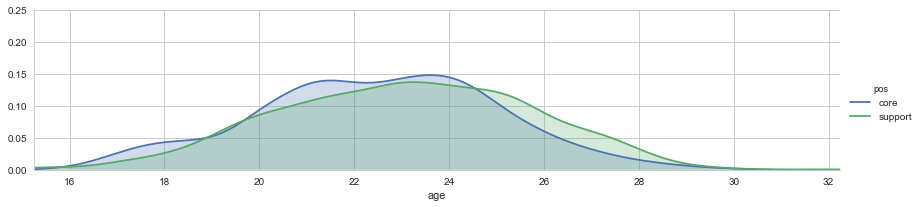

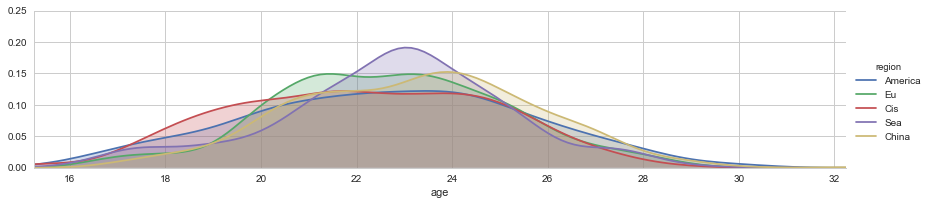

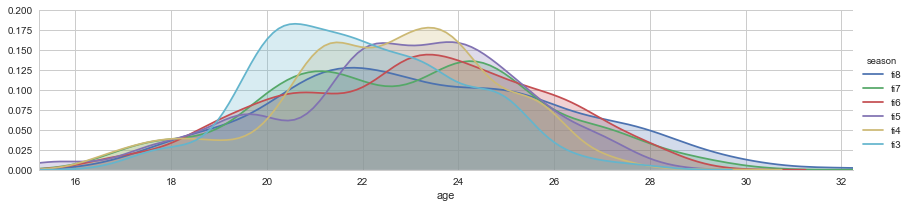

In [15]:
grid1 = sns.FacetGrid( df, hue = 'pos', aspect=4 )
grid1.map(sns.kdeplot, 'age', shade= True )
grid1.set(xlim=(df['age'].min() , df['age'].max()))
grid1.set(ylim=(0, 0.25))
grid1.add_legend()

grid2 = sns.FacetGrid( df, hue = 'region', aspect=4 )
grid2.map(sns.kdeplot, 'age', shade= True )
grid2.set(xlim=(df['age'].min() , df['age'].max()))
grid2.set(ylim=(0, 0.25))
grid2.add_legend()

grid3 = sns.FacetGrid( df, hue = 'season', aspect=4 )
grid3.map(sns.kdeplot, 'age', shade= True )
grid3.set(xlim=(df['age'].min() , df['age'].max()))
grid3.set(ylim=(0, 0.2))
grid3.add_legend()

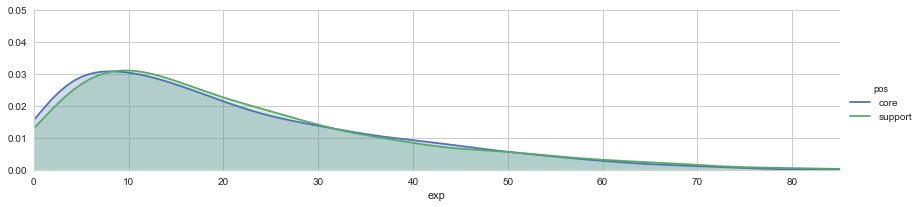

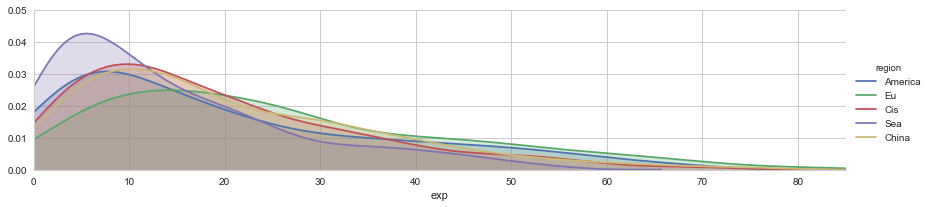

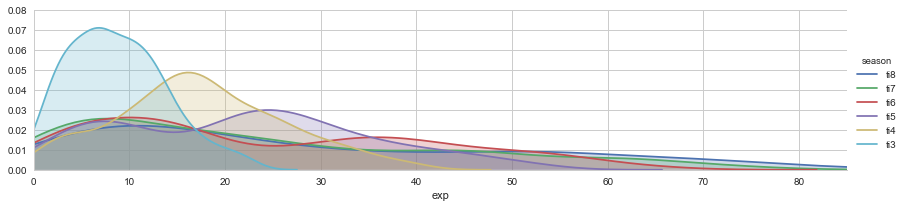

In [16]:
grid1 = sns.FacetGrid( df, hue = 'pos', aspect=4 )
grid1.map(sns.kdeplot, 'exp', shade= True )
grid1.set(xlim=(df['exp'].min() , df['exp'].max()))
grid1.set(ylim=(0, 0.05))
grid1.add_legend()

grid2 = sns.FacetGrid( df, hue = 'region', aspect=4 )
grid2.map(sns.kdeplot, 'exp', shade= True )
grid2.set(xlim=(df['exp'].min() , df['exp'].max()))
grid2.set(ylim=(0, 0.05))
grid2.add_legend()

grid3 = sns.FacetGrid( df, hue = 'season', aspect=4 )
grid3.map(sns.kdeplot, 'exp', shade= True )
grid3.set(xlim=(df['exp'].min() , df['exp'].max()))
grid3.set(ylim=(0, 0.08))
grid3.add_legend()

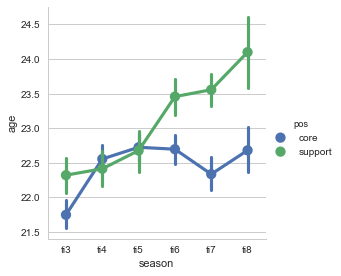

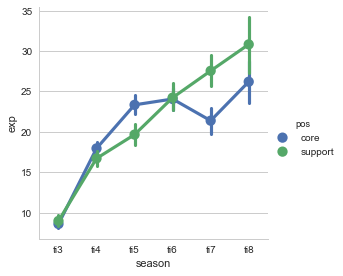

In [17]:
g1 = sns.factorplot(x="season", y="age", hue="pos",
                  order=['ti3', 'ti4', 'ti5', 'ti6', 'ti7', 'ti8'], data=df)

g2 = sns.factorplot(x="season", y="exp", hue="pos",
                  order=['ti3', 'ti4', 'ti5', 'ti6', 'ti7', 'ti8'], data=df)

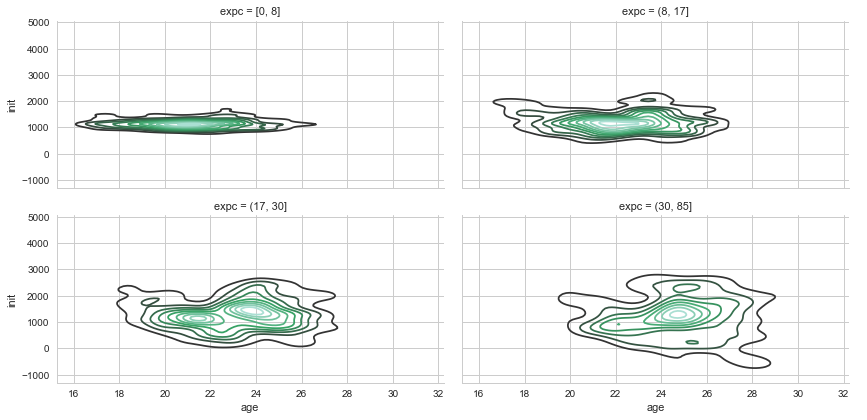

In [27]:
grid = sns.FacetGrid(df, col='expc', aspect=2, col_wrap=2)
grid.map(sns.kdeplot, 'age', 'init')
grid.set(xlim=(df['age'].min() , df['age'].max()))
#grid.set(ylim=(0, 2500))
grid.add_legend()

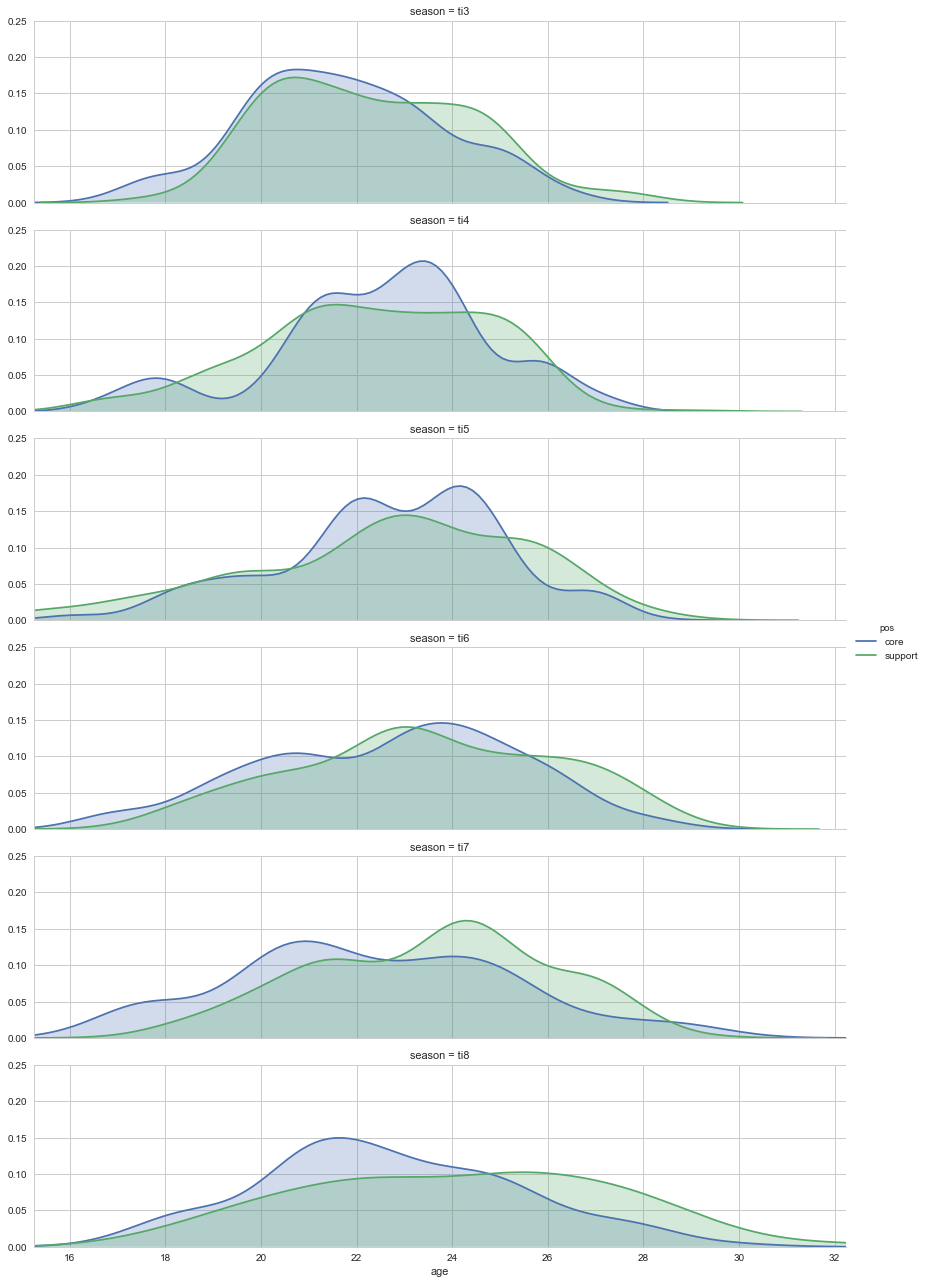

In [19]:
grid1 = sns.FacetGrid(df,row='season', hue='pos', row_order=['ti3', 'ti4', 'ti5', 'ti6', 'ti7', 'ti8'], aspect=4)
grid1.map(sns.kdeplot, 'age', shade= True)
grid1.set(xlim=(df['age'].min() , df['age'].max()))
grid1.set(ylim=(0, 0.25))
grid1.add_legend()

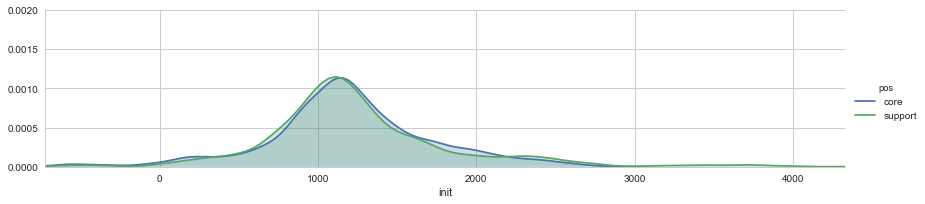

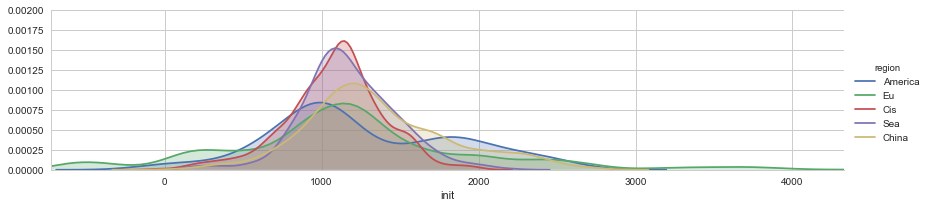

In [20]:
grid1 = sns.FacetGrid( df, hue = 'pos', aspect=4 )
grid1.map(sns.kdeplot, 'init', shade= True )
grid1.set(xlim=(df['init'].min() , df['init'].max()))
grid1.set(ylim=(0, 0.002))
grid1.add_legend()

grid2 = sns.FacetGrid( df, hue = 'region', aspect=4 )
grid2.map(sns.kdeplot, 'init', shade= True )
grid2.set(xlim=(df['init'].min() , df['init'].max()))
grid2.set(ylim=(0, 0.002))
grid2.add_legend()

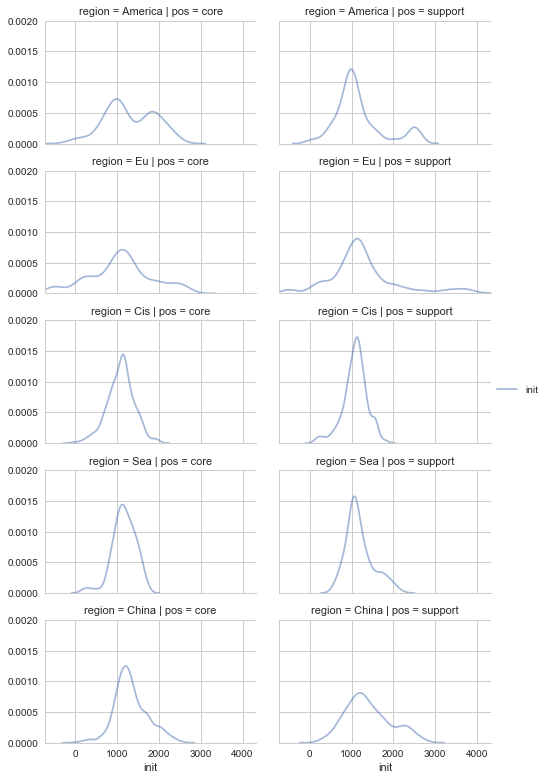

In [21]:
grid = sns.FacetGrid(df, col='pos', row='region', size=2.2, aspect=1.6)
grid.map(sns.kdeplot, 'init', alpha=.5)
grid.set(xlim=(df['init'].min() , df['init'].max()))
grid.set(ylim=(0, 0.002))
grid.add_legend();

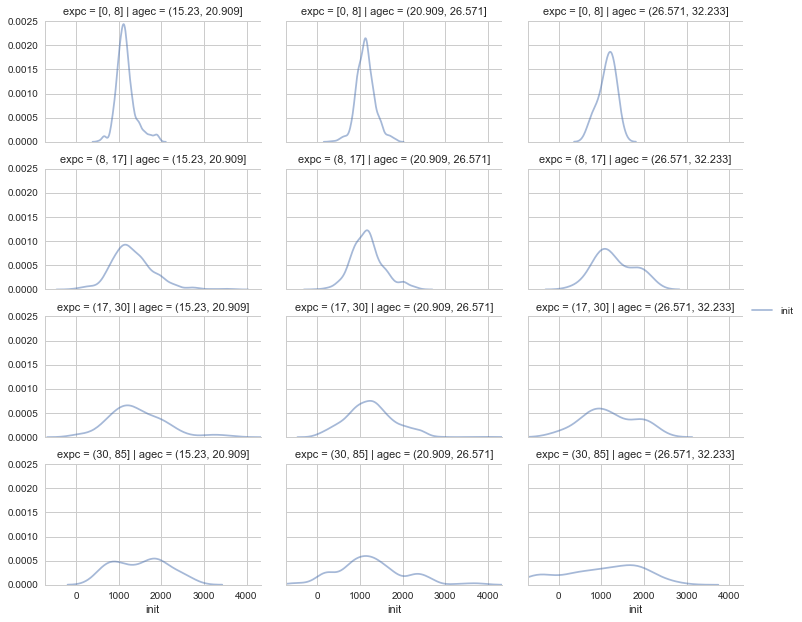

In [22]:
grid = sns.FacetGrid(df, col='agec', row='expc', size=2.2, aspect=1.6)
grid.map(sns.kdeplot, 'init', alpha=.5)
grid.set(xlim=(df['init'].min() , df['init'].max()))
grid.set(ylim=(0, 0.0025))
grid.add_legend();

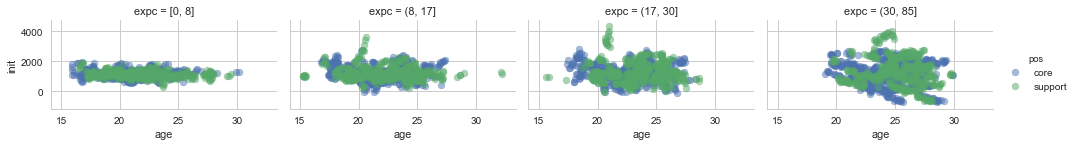

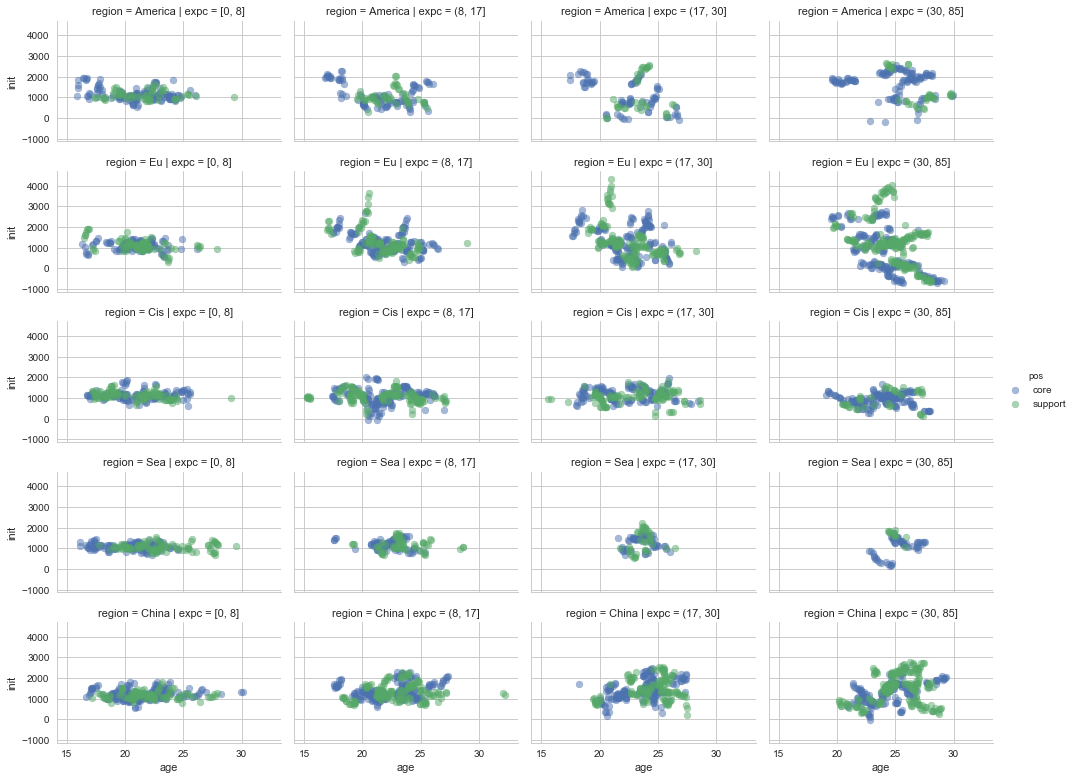

In [23]:
grid1 = sns.FacetGrid(df, col='expc', hue='pos', size=2.2, aspect=1.6)
grid1.map(plt.scatter,'age', 'init', alpha=.5)
grid1.add_legend();

grid2 = sns.FacetGrid(df, col='expc', row='region', hue='pos', size=2.2, aspect=1.6)
grid2.map(plt.scatter,'age', 'init', alpha=.5)
grid2.add_legend();

count    283.000000
mean      22.154543
std        2.768889
min       15.370294
25%       20.291581
50%       21.850787
75%       24.045175
max       32.082136
Name: age, dtype: float64


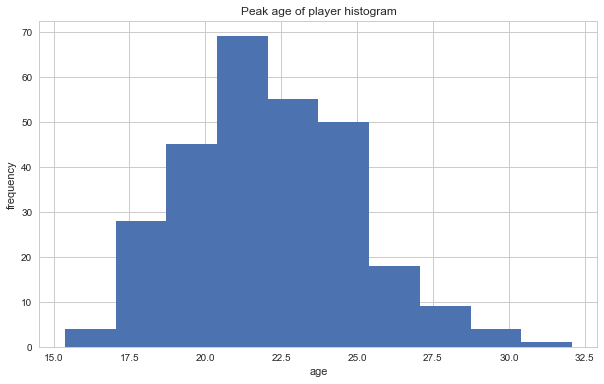

In [64]:
print(df[idx].age.describe())

idx = df.groupby(['player'])['init'].transform(max) == df['init']
fig = plt.figure(figsize=(10, 6))
ax = fig.gca()
df[idx].age.plot.hist(bins=10, ax=ax)
ax.set_title('Peak age of player histogram')
ax.set_xlabel('age')
ax.set_ylabel('frequency')